In [33]:
import sys
import csv
sys.path.append('..')
from BDDData import *
import numpy as np
import torch
import torch.utils.data as data

import networkx as nx
import matplotlib.pyplot as pltk
from scipy.linalg import circulant
from product_graph import *
from utils import *

In [34]:
#Load dataframes
bdd_data = BDD_dataset("raw_data/BDDdata/")
#Add column with the timestep
bdd_data.add_timestep_id()
#Add flags for chaotic values
bdd_data.tag_chaotic(replace=True)
#Compute the mod for the nazelle and wind angles
bdd_data.angle_mod()
#Interpolate the missing values
bdd_data.interpolate_power()
#Values smaller than 0 are set to 0
bdd_data.cap_power_to_zero()
#Normalize Patv feature to [0,1]
bdd_data.normalize_power(min=0, max=1, method= "MinMaxScaler")
#Convert df to matrix form, where only Patv is included. Then split into train, validation and test
#The matrix contains the subset of the time series for ALL nodes, so an (TxN matrix)
train, val, test = bdd_data.split_df()

In [35]:
train = train[:,:1000]
val = val[:, :1000]
test = test[:, :1000]

In [36]:
class CustomBDD_Dataset(data.Dataset):
    def __init__(self, dataset, observation_window=12, forecast_window=12, starting_turbine = 0,  ending_turbine=133):
        self.observation_window = observation_window
        self.forecast_window = forecast_window
        length = eval(f'len({dataset}[0])')#Retrieves length of dataset
        bdd_data.get_observation_forecasting_window(time_series_len=length, observation_steps=self.observation_window, forecast_steps=self.forecast_window)#Generates obs window
        self.window_of_interest =  bdd_data.sliding_indices[str(self.observation_window)+","+str(self.forecast_window)]#Retrieves windows
        self.starting_turbine = starting_turbine
        self.ending_turbine = ending_turbine  
        self.dataset = dataset

    def __len__(self):
        return len(self.window_of_interest)

    def __getitem__(self, idx):
        window = self.window_of_interest[idx]
        if self.dataset == "train":
            features = train[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = train[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "val":
            features = val[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = val[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "test":
            features = test[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = test[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        else:
            raise NotImplementedError
        return torch.from_numpy(features).float(), torch.from_numpy(labels).float()
    
obs_window = 24
forecast_window = 12
batch_size = 100

train_dataset = CustomBDD_Dataset("train",observation_window=obs_window,forecast_window=forecast_window)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size = batch_size)
val_dataset = CustomBDD_Dataset("val",observation_window=obs_window,forecast_window=forecast_window)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size = batch_size)

In [37]:
x,y = next(iter(train_loader))
print(f"{x.shape=}\n{y.shape=}")

x.shape=torch.Size([100, 3216, 1])
y.shape=torch.Size([100, 1608, 1])


In [38]:
G = nx.read_gml('data/spatial_graph_2000.gml')
adj_mat = nx.adjacency_matrix(G)
adj_mat = nx.to_numpy_array(G)


In [39]:
def build_time_graph(window: int, directed: bool, cyclic: bool):
    """
    Circulant matrix as in https://arxiv.org/pdf/1712.00468.pdf (eq. 7)
    """
    if window <= 1:
        raise Exception("Ehm..")
    adjacency = circulant([0, 1] + [0 for _ in range(window-2)])
    if not cyclic:
        adjacency[0, window-1] = 0
    if not directed:
        adjacency += adjacency.transpose()

    return adjacency

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


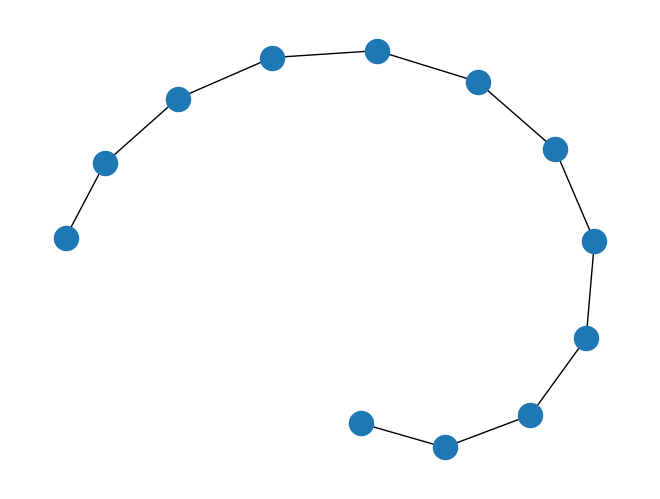

In [40]:
timegraph = build_time_graph(12,True,False)
print(timegraph)
tg = nx.from_numpy_array(timegraph)
nx.draw(tg)

In [41]:
# Normalize the adjacency matrix
S = normalize_adjacency(torch.tensor(adj_mat))
S_t = torch.tensor(timegraph)

In [42]:
print(adj_mat.shape)

(134, 134)


In [43]:
pg = build_parametric_product_graph(S_t, S, 0, 1, 1, 1)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNNLayer(nn.Module):
    def __init__(self, in_features, out_features, order):
        super(GCNNLayer, self).__init__()
        self.order = order
        self.weights = nn.Parameter(torch.FloatTensor(in_features, out_features, order))
        # use Xavier initialization to match variance of input with output
        nn.init.xavier_uniform_(self.weights)

    def forward(self, features, shift_powers):
        batch_size = features.size(0)
        output_dim = self.weights.size(1)
        out = torch.zeros((batch_size, features.size(1), output_dim), device=features.device)     
        
        for k in range(self.order):
            weighted = torch.bmm(features, self.weights[:, :, k].unsqueeze(0).repeat(batch_size, 1, 1))
            shifted = torch.bmm(shift_powers[k].unsqueeze(0).repeat(batch_size, 1, 1), weighted)
            out += shifted
        return out
    

# Inputs must be sized [num_nodes, obs_size] and outputs will be [num_nodes, pred_size]
class GCNN(nn.Module):
    def __init__(self, hid_sizes, shift, order):
        super(GCNN, self).__init__()
        self.layers = nn.ModuleList()
        # set the shift operator
        self.shift_powers = [torch.matrix_power(shift, k).float() for k in range(order)]
        # input layer of size obs_size
        self.layers.append(GCNNLayer(1, hid_sizes[0], order))
        # num_hid hidden layers of size hid_size
        for i in range(len(hid_sizes) - 1):
            self.layers.append(GCNNLayer(hid_sizes[i], hid_sizes[i + 1], order))
        # fully connected layer to get  output of dim pred_size
        self.layers.append(nn.Linear(hid_sizes[-1], 1))

    # Forward sample by sample, no batches are yet supported
    def forward(self, features):
        temp = features
        for layer in self.layers[:-1]:
            # use relu activation function
            temp = F.relu(layer(temp, self.shift_powers))
        return self.layers[-1](temp)
    
    
model = GCNN([128,128],pg,1)

In [45]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_epoch(model, loader, optimizer, device='cpu'):
    model.to(device)
    model.train()
    total_loss = 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        # reshape so that they are in the correct size        
        optimizer.zero_grad()
        outputs = model(x)
        loss = torch.nn.functional.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_epoch(model, loader, device='cpu'):
    model.eval()
    total_loss = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        # reshape so that they are in the correct size        
        outputs = model(x)
        loss = torch.nn.functional.mse_loss(outputs, y)
        total_loss += loss.item()
    return total_loss / len(loader)


def train_model(model, train_loader, val_loader, num_epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs+1):
        train_loss = train_epoch(model, train_loader, optimizer, device=device)
        val_loss = evaluate_epoch(model, val_loader, device=device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 1 == 0:
            print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                  "\t validation loss:", np.round(val_loss,4))

    elapsed_time = time.time() - start_time
    print(f'Model training took {elapsed_time:.3f} seconds')

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader)

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [100, 1608] but got: [100, 3216].